In [3]:
from torchcp.classification.scores import THR, APS, RAPS
from torchcp.classification.predictors import SplitPredictor, ClassWisePredictor, ClusterPredictor
from common.dataset import build_dataset
from common.utils import evaluate_plus
from torchcp.utils import fix_randomness
import torch
import torchvision
import numpy as numpy
import matplotlib.pyplot as plt
import seaborn as sns

fix_randomness(0)

In [4]:
""" Load the datasets"""
id_dataset = build_dataset('imagenet')

cal_dataset, test_dataset = torch.utils.data.random_split(id_dataset, [25000, 25000])
cal_data_loader = torch.utils.data.DataLoader(cal_dataset, batch_size=1024, shuffle=False, pin_memory=True, num_workers=8)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1024, shuffle=False, pin_memory=True, num_workers=8)

ood_dataset = build_dataset('Textures')
ood_data_loader = torch.utils.data.DataLoader(ood_dataset, batch_size=1024, shuffle=False, pin_memory=True, num_workers=8)

In [3]:
""" Calibrate model & Evaluate CP-based OOD detection """
def evaluate_cp(predictor: str, score: str, cal_data_loader, test_data_loader, ood_data_loader, alpha):
    model = torchvision.models.resnet101(weights="IMAGENET1K_V1", progress=True)
    model_device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
    model.to(model_device)

    if score == "THR":
        score_function = THR()
    elif score == "APS":
        score_function = APS()
    else:
        raise ValueError("Invalid score function.")

    if predictor == "SplitPredictor":
        predictor = SplitPredictor(score_function, model)
    elif predictor == "ClassWisePredictor":
        predictor = ClassWisePredictor(score_function, model)
    elif predictor == "ClusterPredictor":
        predictor = ClusterPredictor(score_function, model)
    else:
        raise ValueError("Invalid predictor.")
    
    predictor.calibrate(cal_data_loader, alpha)
    id_result_dict = evaluate_plus(predictor, test_data_loader)
    ood_result_dict = evaluate_plus(predictor, ood_data_loader)

    del model
    return id_result_dict['All_size'], ood_result_dict['All_size']


100%|██████████| 6/6 [00:09<00:00,  1.53s/it]


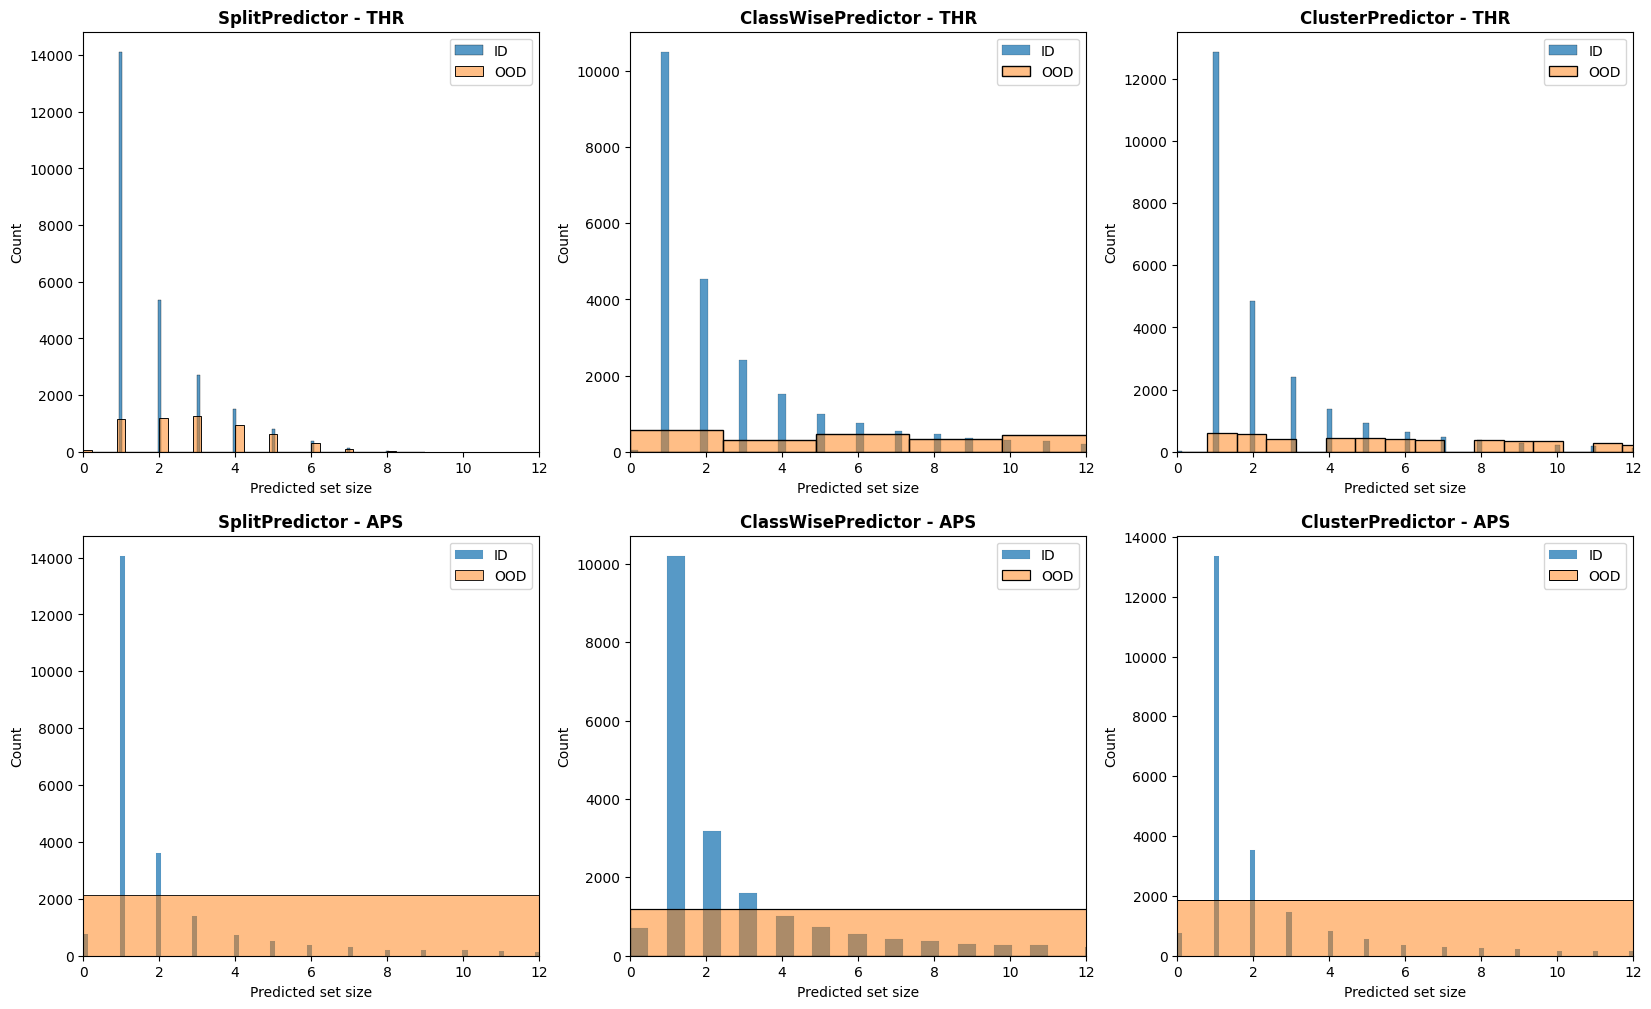

In [4]:
""" Evaluate THR and APS with different predictors """
predictor_list = ['SplitPredictor', "ClassWisePredictor", "ClusterPredictor"]
score_list = ['THR', 'APS']
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
for i, score in enumerate(score_list):
    for j, predictor in enumerate(predictor_list):
        id_size_list, ood_size_list = evaluate_cp(predictor, score, cal_data_loader, test_data_loader, ood_data_loader, 0.1)

        # Plot the histogram
        ax = axes[i, j]
        sns.histplot(id_size_list, label='ID', ax=ax)
        sns.histplot(ood_size_list, label='OOD', ax=ax, alpha=0.5)
        ax.set_xlabel('Predicted set size')
        ax.set_title(f'{predictor} - {score}', fontweight ="bold")
        ax.set_xbound(0, 12)
        ax.legend()

fig.savefig("./fig/dist_thr_aps.pdf", bbox_inches="tight")

In [5]:
""" Calibrate model & Evaluate CP-based OOD detection """
def evaluate_cp_raps(predictor: str, score: str, cal_data_loader, test_data_loader, ood_data_loader, alpha, penalty):
    model = torchvision.models.resnet101(weights="IMAGENET1K_V1", progress=True)
    model_device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
    model.to(model_device)

    if score == "RAPS":
        score_function = RAPS(penalty, kreg=1)
    else:
        raise ValueError("Invalid score function.")

    if predictor == "SplitPredictor":
        predictor = SplitPredictor(score_function, model)
    elif predictor == "ClassWisePredictor":
        predictor = ClassWisePredictor(score_function, model)
    elif predictor == "ClusterPredictor":
        predictor = ClusterPredictor(score_function, model)
    else:
        raise ValueError("Invalid predictor.")
    
    predictor.calibrate(cal_data_loader, alpha)
    id_result_dict = evaluate_plus(predictor, test_data_loader)
    ood_result_dict = evaluate_plus(predictor, ood_data_loader)

    del model
    return id_result_dict['All_size'], ood_result_dict['All_size']


100%|██████████| 10/10 [00:18<00:00,  1.84s/it]
/data/software/anaconda3/envs/py3/lib/python3.11/site-packages/torchcp/classification/predictors/split.py:67: UserWarning: The value of quantile exceeds 1. It should be a value in (0,1). To avoid program crash, the threshold is set as torch.inf.
  warnings.warn(
100%|██████████| 10/10 [00:17<00:00,  1.77s/it]


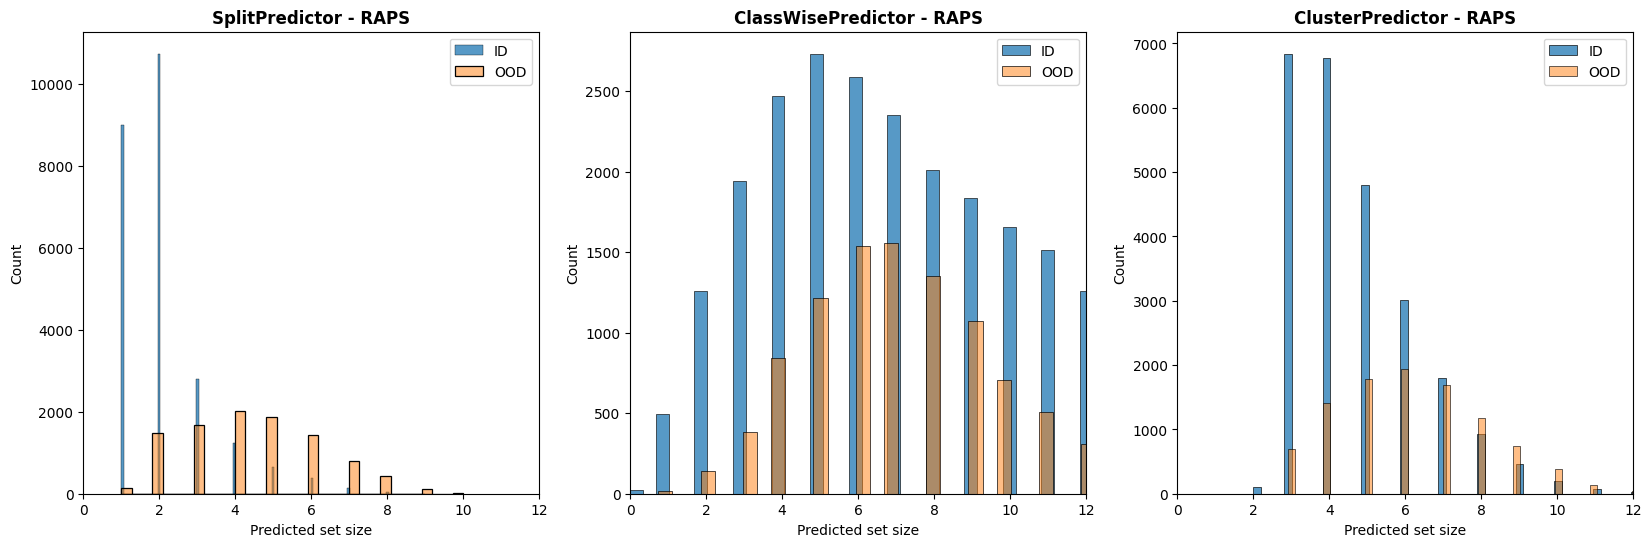

In [8]:
""" Evaluate RAPS with different predictors """
penalty = 0.1
predictor_list = ['SplitPredictor', "ClassWisePredictor", "ClusterPredictor"]
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

ood_dataset = build_dataset('iNaturalist')
ood_data_loader = torch.utils.data.DataLoader(ood_dataset, batch_size=1024, shuffle=False, pin_memory=True, num_workers=8)

for j, predictor in enumerate(predictor_list):
    id_size_list, ood_size_list = evaluate_cp_raps(predictor, 'RAPS', cal_data_loader, test_data_loader, ood_data_loader, 0.1, penalty)

    # Plot the histogram
    ax = axes[j]
    sns.histplot(id_size_list, label='ID', ax=ax)
    sns.histplot(ood_size_list, label='OOD', ax=ax, alpha=0.5)
    ax.set_xlabel('Predicted set size')
    ax.set_title(f'{predictor} - RAPS', fontweight ="bold")
    ax.set_xbound(0, 12)
    ax.legend()

fig.savefig("./fig/dist_raps.pdf", bbox_inches="tight")